# Image Segmentation 

In [1]:
import cv2 as cv 
import matplotlib.pyplot as plt 
import numpy as np 

##  Thresholding Segmentation 

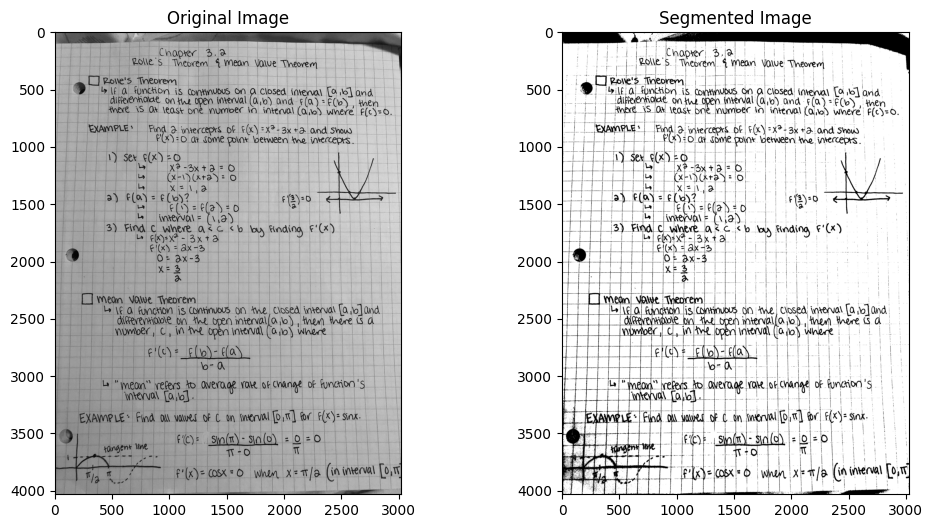

In [ ]:
## Simple thresholding ##

image = cv.imread("./images/handwritten.jpg", 0)

# apply thresholding on the image 
t = 120
retval, binary = cv.threshold(image, thresh=t, maxval=255, type=cv.THRESH_BINARY)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.imshow(image, cmap='grey')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(binary, cmap='grey')
plt.title("Segmented Image")

plt.show()

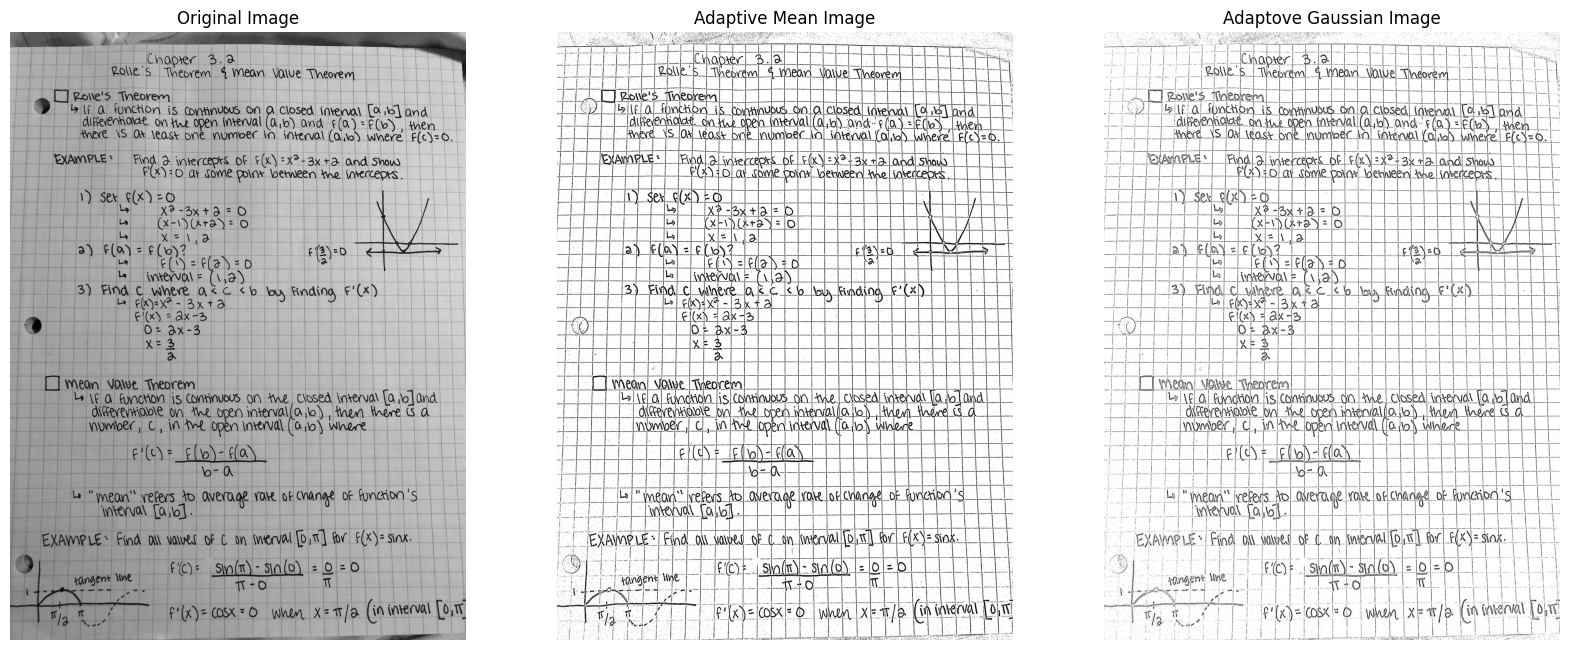

In [ ]:
## Adaptive Thresholding ##

adaptive_mean = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 11, 9)
adaptive_gaussian = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 9)

plt.figure(figsize=(20,30))

plt.subplot(1,3,1)
plt.imshow(image, cmap='grey')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(adaptive_mean, cmap='grey')
plt.title("Adaptive Mean Image")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(adaptive_gaussian, cmap='grey')
plt.title("Adaptove Gaussian Image")
plt.axis('off')

plt.show()

# Play with the c value in the thresholding to make the image more clean

## k-means Clustering for Segmentation

In [ ]:
# kmeans can be done on the rgb image itself
image = cv.imread('./images/shapes.jpg')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

# Reshape image to use it in kmeans
# reshape the image, keeping 3 columns for each value in the array (rgb), all in a 2d list reshaped
# flattening of the image
pixel_values = image_rgb.reshape((-1,3))

print(pixel_values)

[[247 247 247]
 [247 247 247]
 [247 247 247]
 ...
 [247 247 247]
 [247 247 247]
 [247 247 247]]


In [18]:
# convert image in float value to use kmeans 
pixel_values = np.float32(pixel_values)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.2) # defining criteria and apply kmeans
k = 4 # number of classes 

# criteria define the stopping criteria for kmeans clustering algorithm 
# 0.2 define the accepted loss when stopping and max criteria as 100 iterations. 

_, labels, centers = cv.kmeans(pixel_values, k, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

In [19]:
print("labels: \n", labels)
print("\nlabels shape: ", labels.shape)
print("\ncenters: \n", centers)


labels: 
 [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]

labels shape:  (547600, 1)

centers: 
 [[247.90712   242.72005   243.01018  ]
 [  2.1487255 175.04913    88.329475 ]
 [254.24905   119.179054   25.097229 ]
 [  2.66567   126.21679   248.14487  ]]


In [20]:
print(labels.flatten())
print(centers[labels.flatten()])

[0 0 0 ... 0 0 0]
[[247.90712 242.72005 243.01018]
 [247.90712 242.72005 243.01018]
 [247.90712 242.72005 243.01018]
 ...
 [247.90712 242.72005 243.01018]
 [247.90712 242.72005 243.01018]
 [247.90712 242.72005 243.01018]]


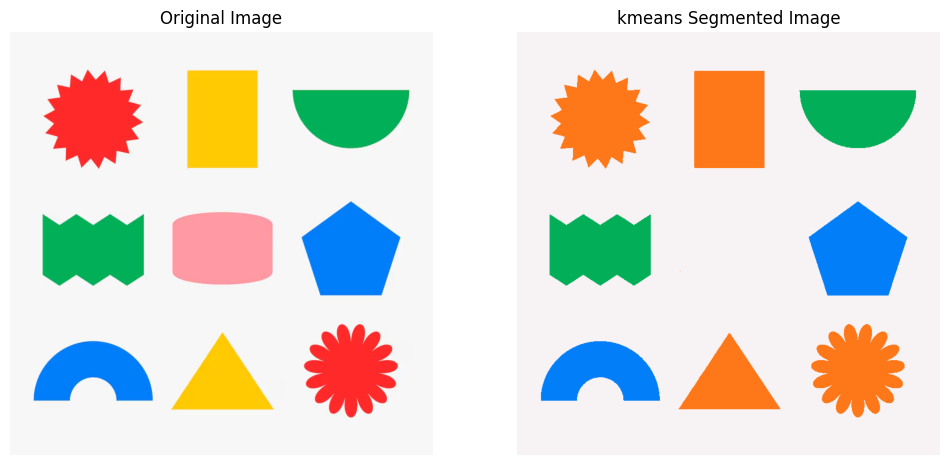

In [21]:
# create back the image based on centers
centers = np.uint8(centers)

# access each value based on the labels 
# you acces each pixel and assign the value of intensity corresponding to its class 
segmented_image = centers[labels.flatten()]

# reshape 
segmented_image = segmented_image.reshape(image_rgb.shape)

plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(segmented_image)
plt.title("kmeans Segmented Image")
plt.axis('off')


plt.show()

# When segmenting, the third class correspond to the the whole image background, infact the ;ast centroid which is close to white (gray) 
# is part of the segmentation

## Watershed Segmentation Algorithm

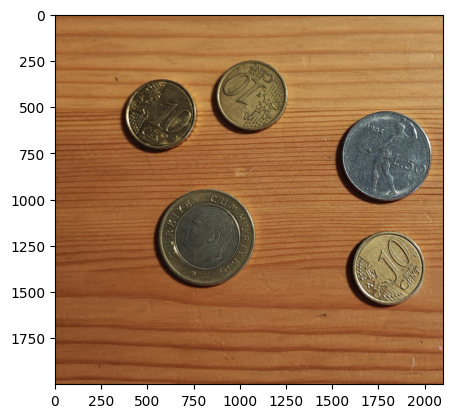

In [2]:
image = cv.imread("./images/coin.jpg")
image = image[500:2500, 0:2100]
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)


plt.imshow(image_rgb)

# create a copy of the image, as separate image memory 
original_image = image_rgb.copy()

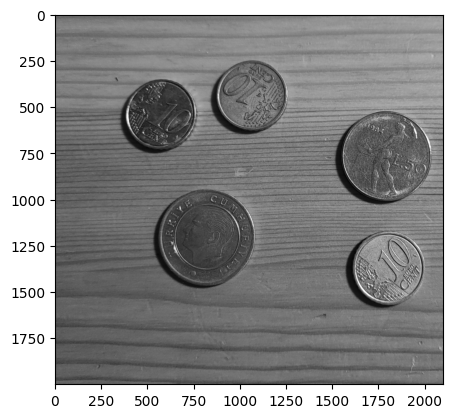

In [3]:
# The steps to apply watershed: 

# convert to grayscale 
image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap='grey')

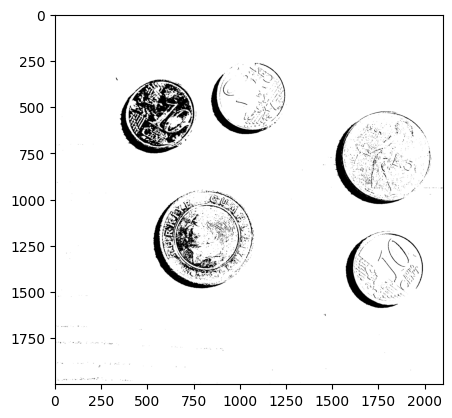

In [4]:
# apply binary threshold creating a mask 
_, thresh = cv.threshold(image_gray, 60, 255, cv.THRESH_BINARY)
plt.imshow(thresh, cmap='grey')

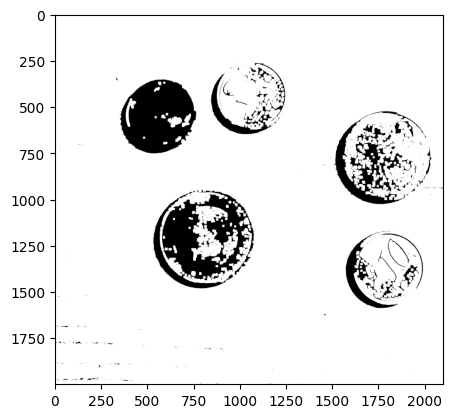

In [5]:
# Remove noise by morphological transform 
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=5)

plt.imshow(opening, cmap='grey')

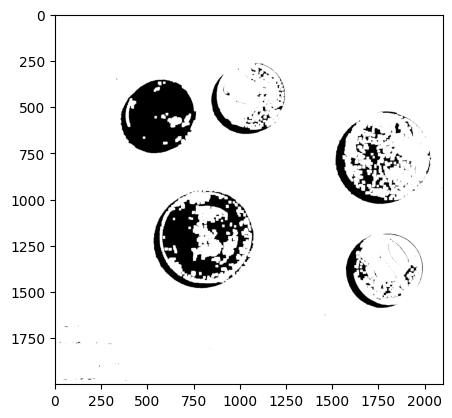

In [6]:
# after remobving noise, try to find background vs foregroung 
sure_bg = cv.dilate(opening, kernel, iterations=1) # take only backgorund
plt.imshow(sure_bg, cmap='grey')

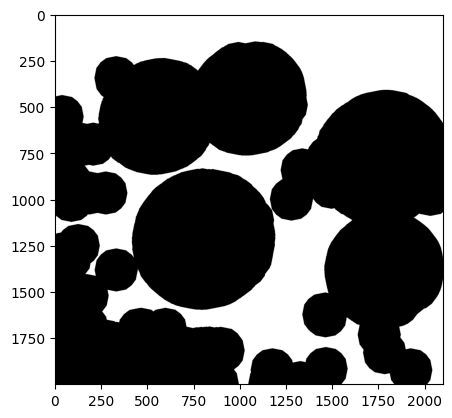

In [7]:
# To extract foreground, we refear to the distance from the object center to the backgorund
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)

# convert distance map taking pixel above a distance threshold 
# plt.imshow(dist_transform, cmap='grey')

# This map is used to create sure foreground
_, sure_fg = cv.threshold(dist_transform, 0.2 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, cmap='grey')
# Show what we are sure that it is in the foreground 

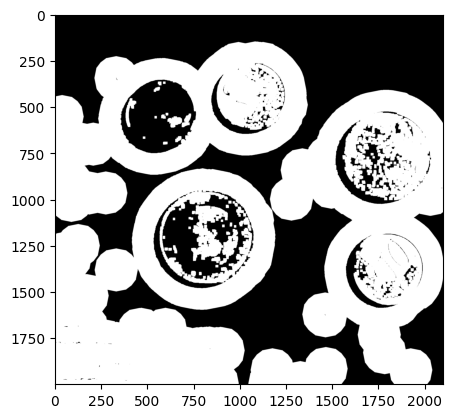

In [8]:
# The unknown region is the area where we don't know if it is foreground or background 
unkown = cv.subtract(sure_bg, sure_fg)
plt.imshow(unkown, cmap='grey')
# Region where we are not sure if it is foreground or background from the image 

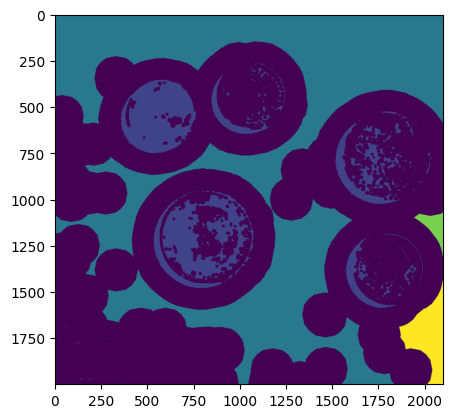

In [9]:
# The unkown part is used to generate markers for watershed 
_, markers = cv.connectedComponents(sure_fg)
markers = markers + 1

markers[unkown == 255] = 0 # wherever it is unkown it is a class of 0 
plt.imshow(markers)

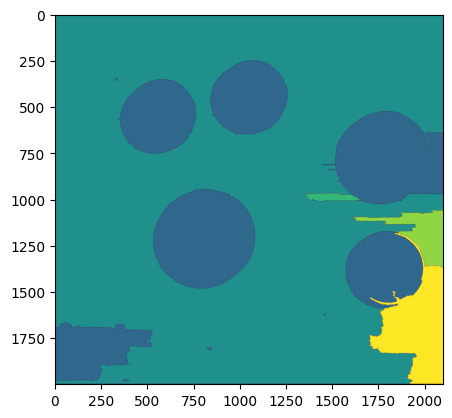

In [10]:
# Finally markers are used for waterhsed 
markers = cv.watershed(image, markers)
plt.imshow(markers)

In [11]:
# Now do circularity check, and take only object that are circular in nature 
coin_mask = np.zeros_like(image_gray) # create a zero value such as image_gray in shape 

print(image_gray.shape)
print(coin_mask.shape)

(2000, 2100)
(2000, 2100)


In [43]:
# find unique markers 
# zeros mask 
unique_labels = np.unique(markers)
coin_mask = np.zeros_like(image_gray)
original_image = image_rgb.copy()
mask = np.zeros_like(image_gray)

# define utility variable 
instance_number = 1
font = cv.FONT_HERSHEY_SIMPLEX

circularities = []

# loop over interesting labels where markers is not zero 
for label in unique_labels: 
    if label == 0 or label == -1: # label 0 or -1 is watershed line 
        continue


    # extract where markers is equal to the current label 
    mask = np.uint8(markers == label)
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    # apply contour detection and check circularity over shapes 
    for contour in contours:
        area = cv.contourArea(contour)
        # check circularity
        perimeter = cv.arcLength(contour, True)

        if perimeter == 0: 
            continue
        
        circularity = 4 * np.pi * (area / perimeter * perimeter)


        if circularity > 1500000 and  100000 < area < 250000: 

            print(f"New object {instance_number}")
            print("circularity: ", circularity)
            print("perimeter: ", perimeter)
            print("area: ", area)
            print("\n")
            
            cv.drawContours(original_image, [contour], -1, (0, 255, 0), 2)
            x, y, w, h = cv.boundingRect(contour)
            cv.putText(original_image, f'Coin {instance_number}', (x, y-20), font, 2.5, (0, 0, 0), 8)
            coin_mask = cv.bitwise_or(coin_mask, mask)
            cv.rectangle(original_image, (x-5, y-5), (x+w+5, y+h+5), (160, 150, 250), 2)

            instance_number += 1
            circularities.append(circularity)



New object 1
circularity:  1620395.7916097722
perimeter:  2064.0571191310883
area:  128947.0


New object 2
circularity:  2855864.801745801
perimeter:  1944.7017803192139
area:  227262.5


New object 3
circularity:  2890981.524427628
perimeter:  2611.9494746923447
area:  230057.0


New object 4
circularity:  1581741.6356000034
perimeter:  1488.7291318178177
area:  125871.0


New object 5
circularity:  1599384.8199425638
perimeter:  1474.0184556245804
area:  127275.0


New object 6
circularity:  1940850.8086465455
perimeter:  3489.693762898445
area:  154448.0




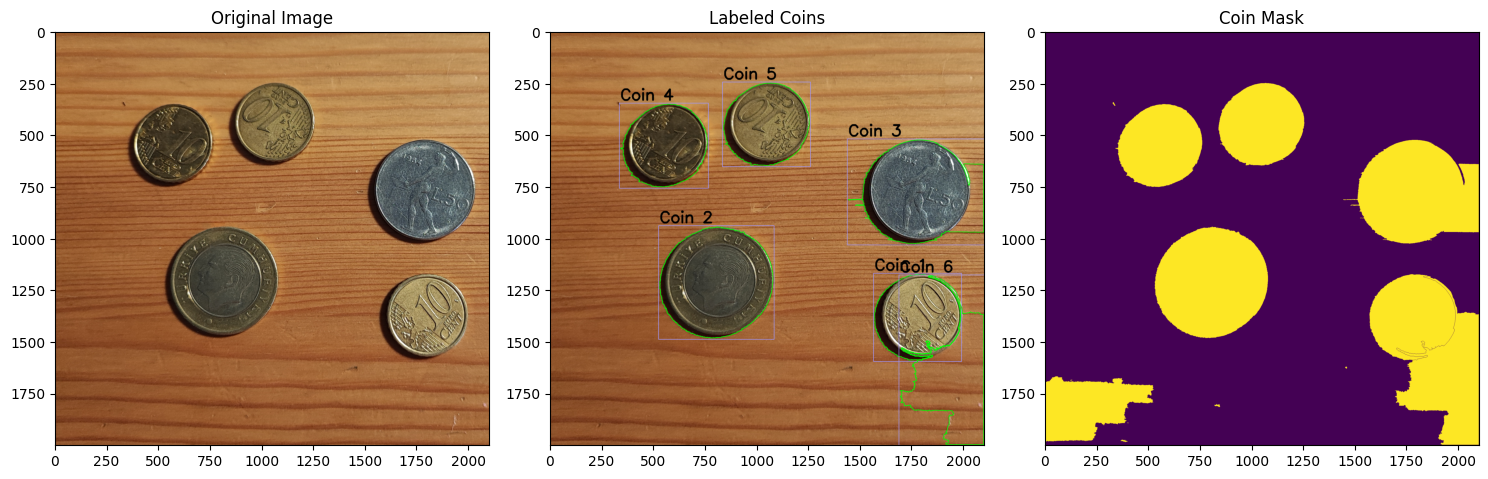

In [44]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(original_image)
plt.title("Labeled Coins")

plt.subplot(1, 3, 3)
plt.imshow(coin_mask)
plt.title("Coin Mask")

plt.tight_layout()
plt.show()

In [46]:
# Watershed require fine tuning in order to work properly. Here it is working badly (different image from original video)
# It require proper testing and fine tuning on specific use cases 
